In [38]:
from sklearn.datasets._samples_generator import make_blobs
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns
import random
import numpy as np

In [39]:
random.seed(42)
rnd = random.randint(3, 10)

In [40]:
X, val = make_blobs(n_samples=500, centers=rnd, cluster_std=0.8, random_state=42)

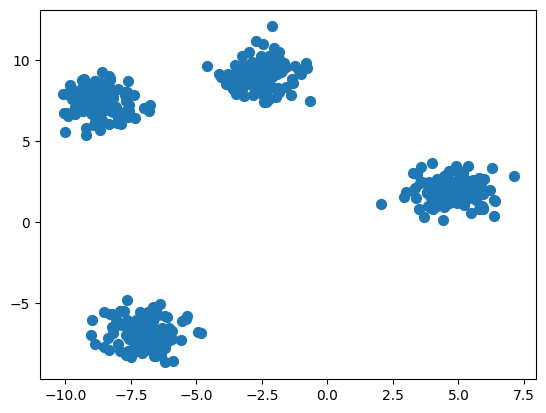

In [41]:
plt.scatter(X[:,0], X[:,1], s=50)

In [42]:
kmeans = KMeans(n_clusters=rnd)
kmeans.fit(X)
y = kmeans.predict(X)

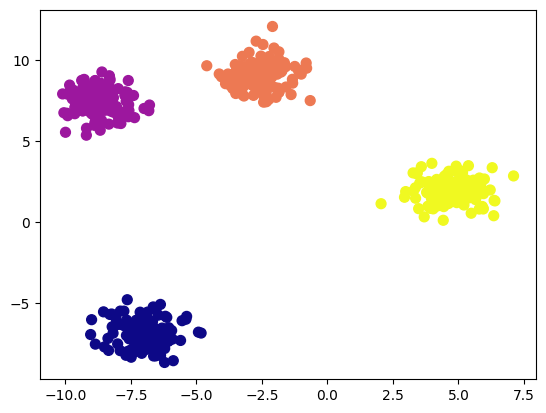

In [43]:
plt.scatter(X[:,0], X[:,1], c=y, s=50, cmap="plasma")
centroids = kmeans.cluster_centers_

In [44]:
def getBlobs(i):
  random.seed(i)
  nr = random.randint(3,10)
  return make_blobs(n_samples=500, centers=nr, cluster_std=0.8, random_state=nr*i)
  # plt.scatter(X[:,0],X[:,1])
  # plt.show()
  

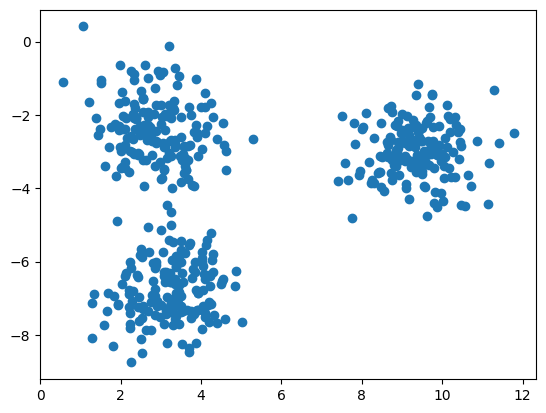

In [45]:
X, val = getBlobs(10)
plt.scatter(X[:,0],X[:,1])
plt.show()

In [46]:

ssd = {}
for k in range(1,20):
  kmeans = KMeans(init="k-means++", n_clusters=k)
  kmeans.fit(X)
  ssd[k] = kmeans.inertia_
  
ssd

{1: 6881.244170618385,
 2: 2212.4399233175973,
 3: 613.9042274680983,
 4: 535.0621690492661,
 5: 455.8256815525374,
 6: 391.3334987145355,
 7: 352.68619222188056,
 8: 353.3286235865541,
 9: 272.9158009155015,
 10: 258.7540833751802,
 11: 229.37134031781792,
 12: 207.45821046641043,
 13: 202.57349749294337,
 14: 187.50759994856963,
 15: 168.26944898199505,
 16: 169.40612670274973,
 17: 153.20685997858348,
 18: 145.02288400406425,
 19: 139.20896624554993}

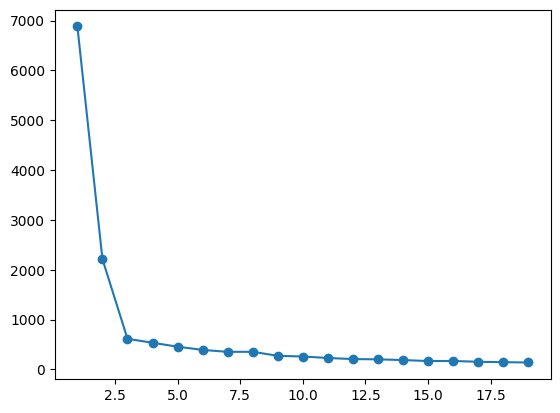

In [47]:
plt.plot(list(ssd.keys()), list(ssd.values()), marker="o")

probabilmente ci saranno 3 centroidi

In [48]:
kmeans_def = KMeans(init="k-means++", n_clusters=3)
kmeans_def.fit(X)
y_def = kmeans_def.predict(X)

In [49]:
centroids_def = kmeans_def.cluster_centers_

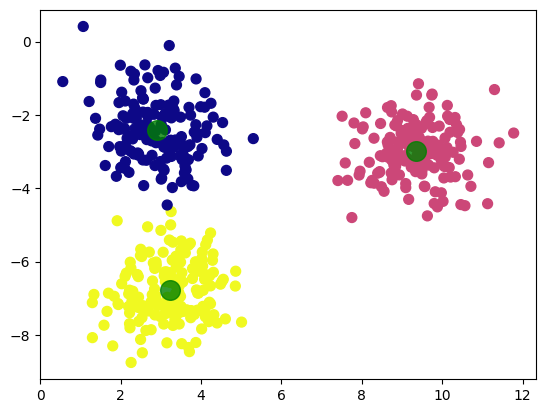

In [50]:
plt.scatter(X[:,0], X[:,1], c=y_def, s=50, cmap="plasma")
plt.scatter(centroids_def[:, 0], centroids_def[:, 1], c='green', s=200, alpha=0.8)

ora proviamo ad esplorare se esiste un modo automatico per eseguire il controllo sulla clusterizzazione

In [51]:
from scipy.signal import savgol_filter

def trova_k_ottimale_gomito_robusto(k_range, inertias, use_smoothing=True, smoothing_window=5):
    if len(k_range) < 2:
        print("Sono necessari almeno 2 punti per il calcolo.")
        return None

    inertias_np = np.array(inertias)
    k_range_np = np.array(k_range)

    if use_smoothing:
        if smoothing_window < 3 or smoothing_window % 2 == 0:
            raise ValueError("smoothing_window deve essere un intero dispari >= 3.")
        if smoothing_window > len(inertias_np):
            print("Avviso: La finestra di smoothing è troppo grande per i dati. Smoothing disabilitato.")
            inertias_smoothed = inertias_np
        else:
            inertias_smoothed = savgol_filter(inertias_np, window_length=smoothing_window, polyorder=2)
    else:
        inertias_smoothed = inertias_np

    points = np.array(list(zip(k_range_np, inertias_smoothed)))
    p1 = points[0]
    p2 = points[-1]

    A = p2[1] - p1[1]
    B = p1[0] - p2[0]
    C = -A * p1[0] - B * p1[1]

    distances = []
    for i in range(len(points)):
        x0, y0 = points[i]
        distance = abs(A * x0 + B * y0 + C) / np.sqrt(A**2 + B**2 + 1e-10)

        distances.append(distance)

    optimal_k_index = np.argmax(distances)
    optimal_k = k_range_np[optimal_k_index]

    print(f"K ottimale stimato: {optimal_k} (Metodo distanza da linea, Smoothing: {use_smoothing})")

    plt.figure(figsize=(10, 6))
    plt.plot(k_range, inertias, marker='o', label='Inerzia Originale')
    if use_smoothing:
        plt.plot(k_range_np, inertias_smoothed, marker='x', linestyle='--', color='orange', label='Inerzia Livigata')
    plt.plot([p1[0], p2[0]], [p1[1], p2[1]], 'r--', label='Linea di base')
    plt.plot(optimal_k, inertias_smoothed[optimal_k_index], 'go', markersize=10, label=f'Gomito stimato K={optimal_k}')
    plt.xlabel('Numero di Cluster (K)')
    plt.ylabel('Inerzia')
    plt.title('Metodo del Gomito (Robusto)')
    plt.grid(True)
    plt.xticks(k_range)
    plt.legend()
    plt.show()

    return optimal_k

In [52]:
def automatize_elbow_method(k_range, inertias, plot_results=True):
    if len(k_range) < 2:
        print("Sono necessari almeno 2 punti per il calcolo.")
        return None

    inertias_np = np.array(inertias)
    k_range_np = np.array(k_range)

    if len(inertias_np) > 1:
        diffs = np.diff(inertias_np)
        std_diffs = np.std(diffs)
    else:
        std_diffs = 0

    inertia_range = np.max(inertias_np) - np.min(inertias_np)
    if inertia_range == 0:
        relative_noise = 0
    else:
        relative_noise = std_diffs / inertia_range
    calculated_smoothing_window = 3 
    
    if relative_noise > 0:
        calculated_window_raw = int(3 + relative_noise * 20)
        
        if calculated_window_raw % 2 == 0:
            calculated_window_raw += 1
            
        calculated_smoothing_window = calculated_window_raw

    max_possible_window = len(inertias_np) - 1

    if max_possible_window < 3:
        inertias_smoothed = inertias_np
        use_smoothing_actual = False
        calculated_smoothing_window = 0
    else:
        calculated_smoothing_window = np.clip(calculated_smoothing_window, 3, max_possible_window)
        
        if calculated_smoothing_window % 2 == 0:
            calculated_smoothing_window += 1
            if calculated_smoothing_window > max_possible_window:
                calculated_smoothing_window = max_possible_window if max_possible_window % 2 != 0 else max_possible_window - 1
                if calculated_smoothing_window < 3: calculated_smoothing_window = 3

        inertias_smoothed = savgol_filter(inertias_np, window_length=calculated_smoothing_window, polyorder=2)
        use_smoothing_actual = True


    points = np.array(list(zip(k_range_np, inertias_smoothed)))
    p1 = points[0]
    p2 = points[-1]

    A = p2[1] - p1[1]
    B = p1[0] - p2[0]
    C = -A * p1[0] - B * p1[1]

    distances = []
    denominator = np.sqrt(A**2 + B**2)
    if denominator == 0:
        print("Avviso: La linea di base è piatta o i punti iniziale/finale coincidono. Impossibile calcolare distanza.")
        return None

    for i in range(len(points)):
        x0, y0 = points[i]
        distance = abs(A * x0 + B * y0 + C) / denominator
        distances.append(distance)

    if not distances or np.all(np.array(distances) == 0):
        print("Avviso: Tutte le distanze dalla linea di base sono zero o non ci sono punti validi per il calcolo.")
        return None

    optimal_k_index = np.argmax(distances)
    optimal_k = k_range_np[optimal_k_index]

    window_display = f"Adattiva ({calculated_smoothing_window})" if use_smoothing_actual else "Nessuno"
    print(f"K ottimale stimato: {optimal_k} (Metodo distanza da linea, Smoothing: {window_display})")

    if plot_results:
        plt.figure(figsize=(10, 6))
        plt.plot(k_range, inertias, marker='o', label='Inerzia Originale')
        if use_smoothing_actual:
            plt.plot(k_range_np, inertias_smoothed, marker='x', linestyle='--', color='orange', label=f'Inerzia Livigata (Finestra={calculated_smoothing_window})')
        plt.plot([p1[0], p2[0]], [p1[1], p2[1]], 'r--', label='Linea di base')
        plt.plot(optimal_k, inertias_smoothed[optimal_k_index], 'go', markersize=10, label=f'Gomito stimato K={optimal_k}')
        plt.xlabel('Numero di Cluster (K)')
        plt.ylabel('Inerzia')
        plt.title('Metodo del Gomito (Robusto e Autonomo)')
        plt.grid(True)
        plt.xticks(k_range)
        plt.legend()
        plt.show()

    return optimal_k



K ottimale stimato: 4 (Metodo distanza da linea, Smoothing: Adattiva (7))


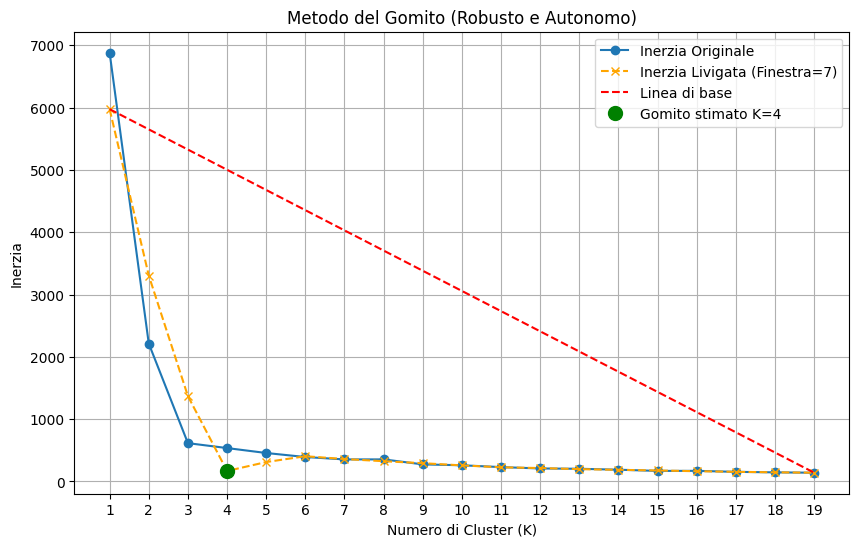

In [53]:
optimal_k = automatize_elbow_method(list(ssd.keys()), list(ssd.values()))

In [54]:
optimal_k

np.int64(4)

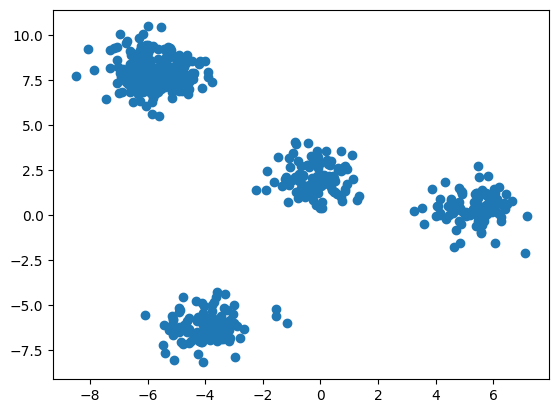

K ottimale stimato: 5 (Metodo distanza da linea, Smoothing: Adattiva (7))


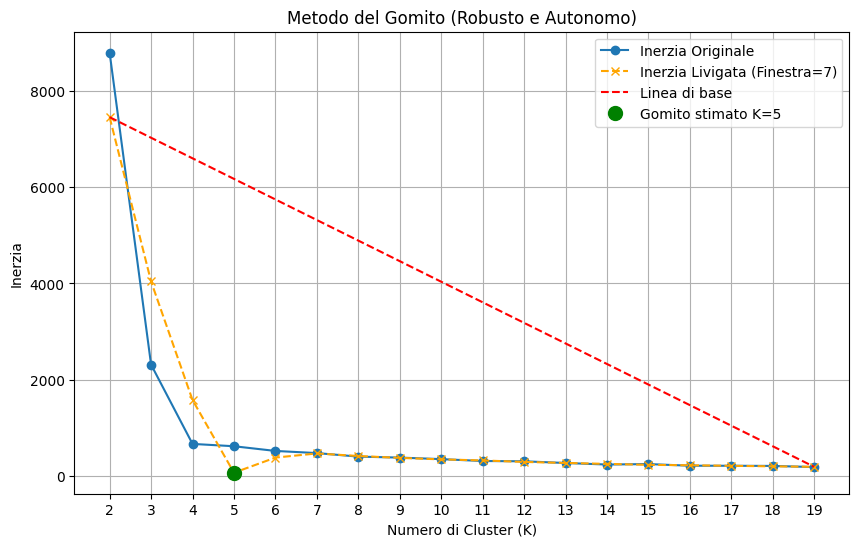

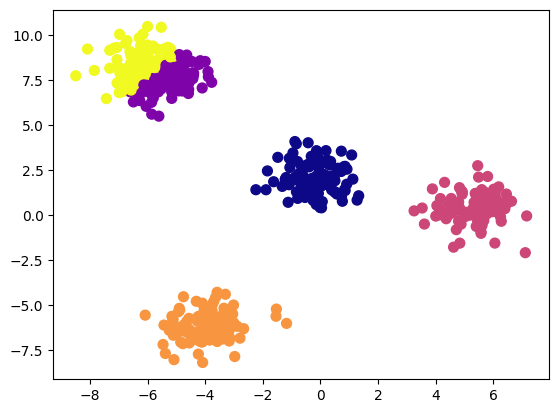

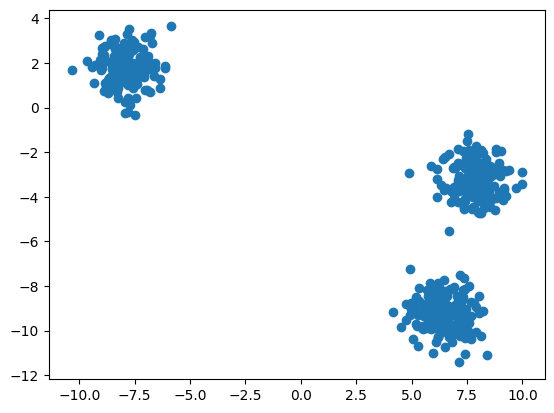

K ottimale stimato: 5 (Metodo distanza da linea, Smoothing: Adattiva (7))


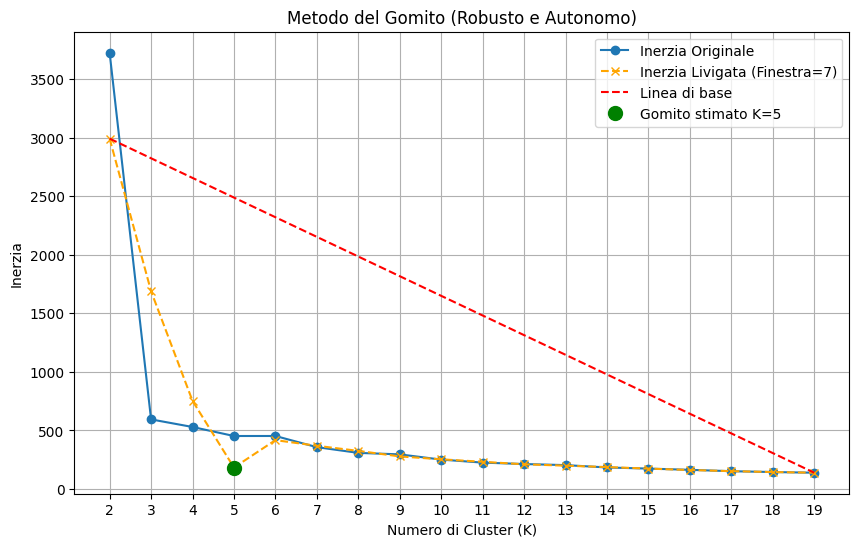

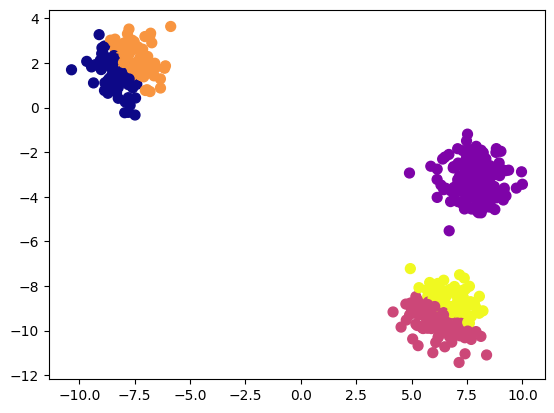

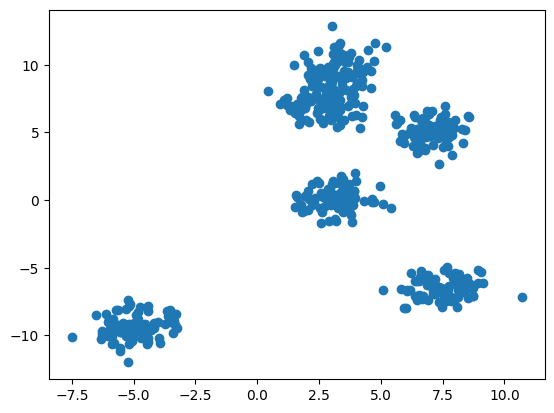

K ottimale stimato: 5 (Metodo distanza da linea, Smoothing: Adattiva (7))


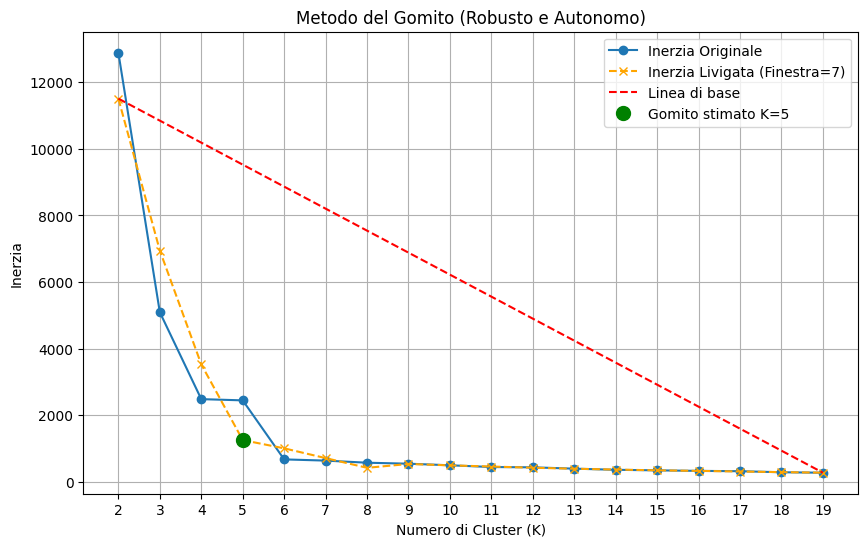

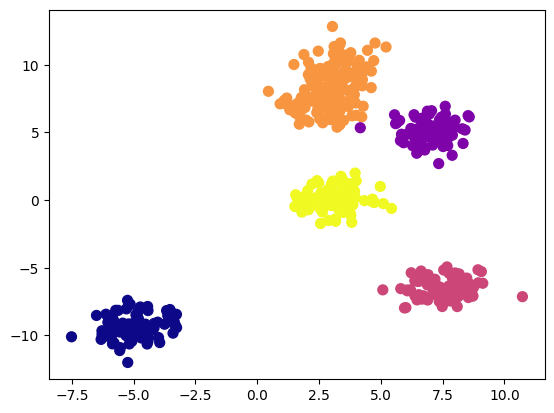

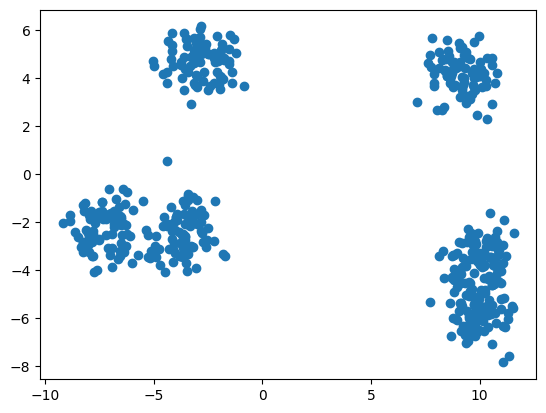

K ottimale stimato: 5 (Metodo distanza da linea, Smoothing: Adattiva (5))


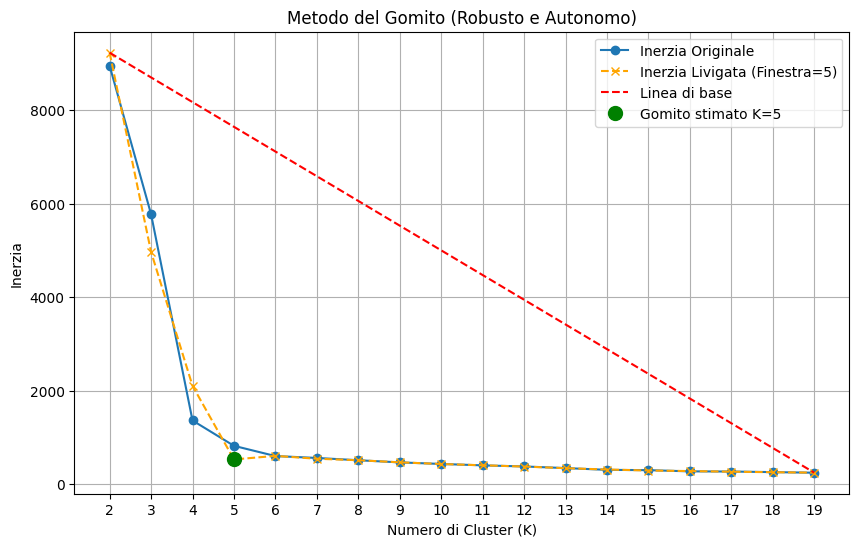

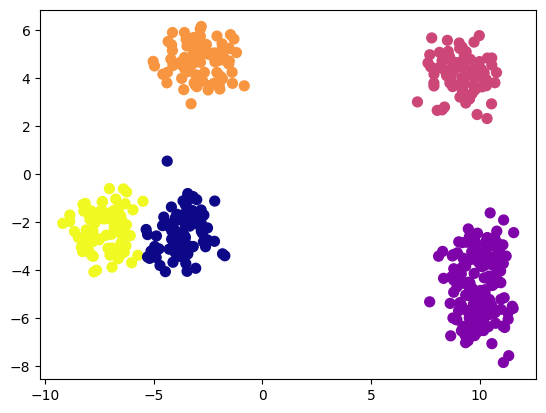

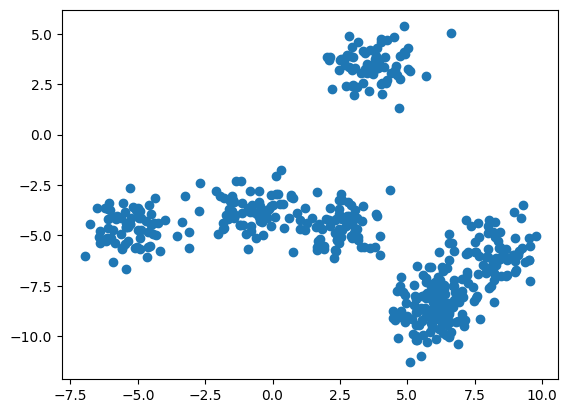

K ottimale stimato: 5 (Metodo distanza da linea, Smoothing: Adattiva (5))


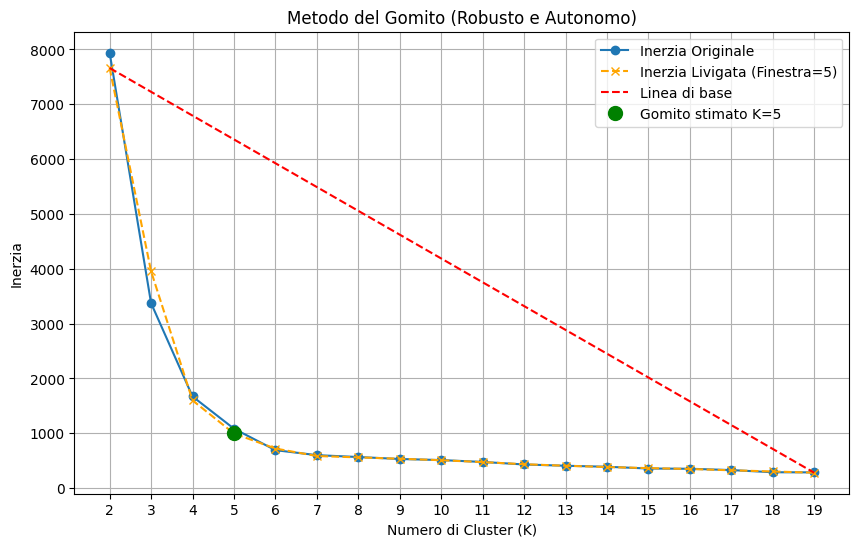

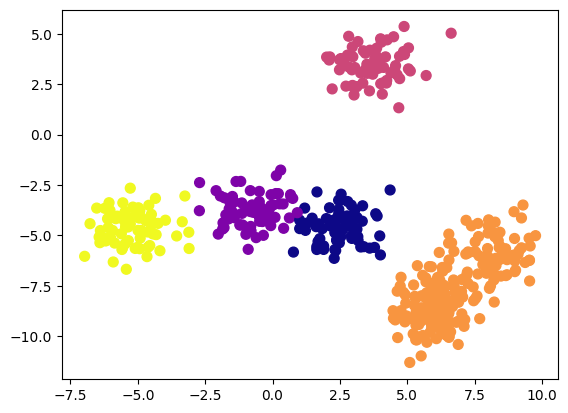

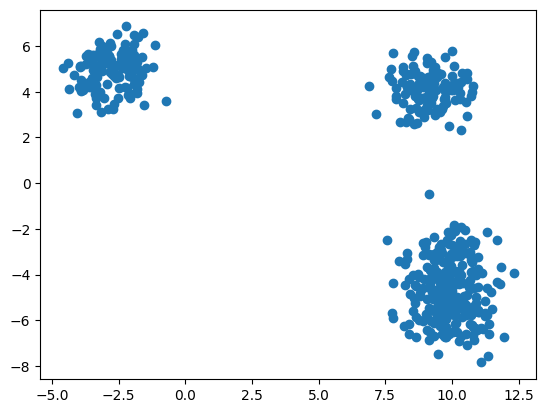

K ottimale stimato: 5 (Metodo distanza da linea, Smoothing: Adattiva (7))


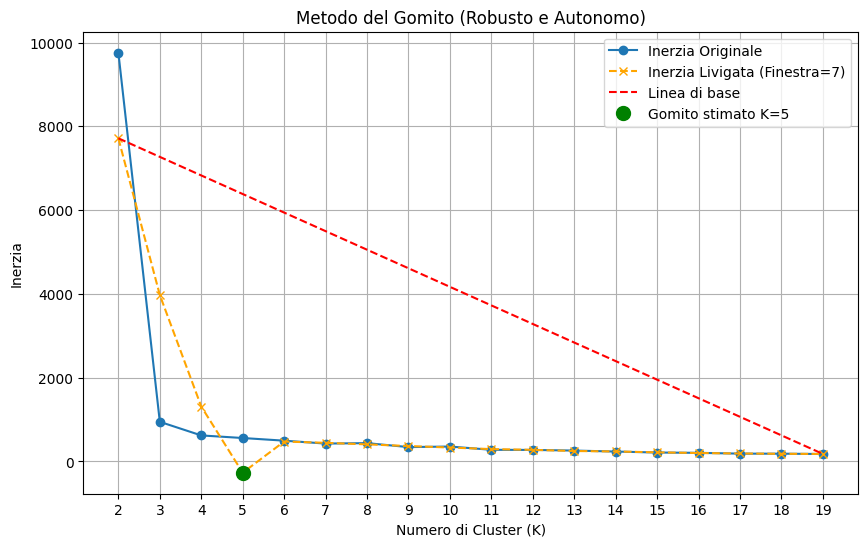

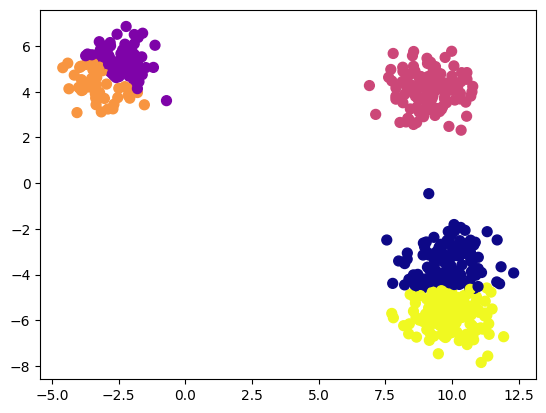

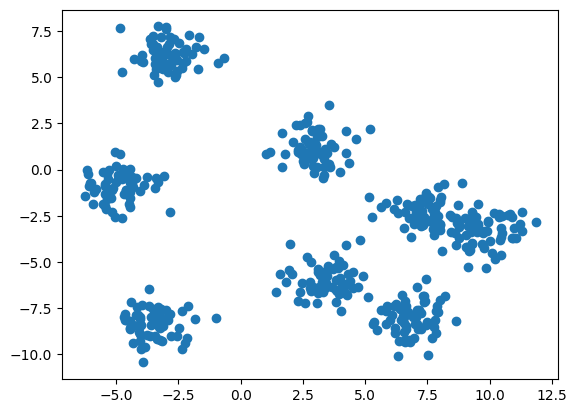

K ottimale stimato: 6 (Metodo distanza da linea, Smoothing: Adattiva (5))


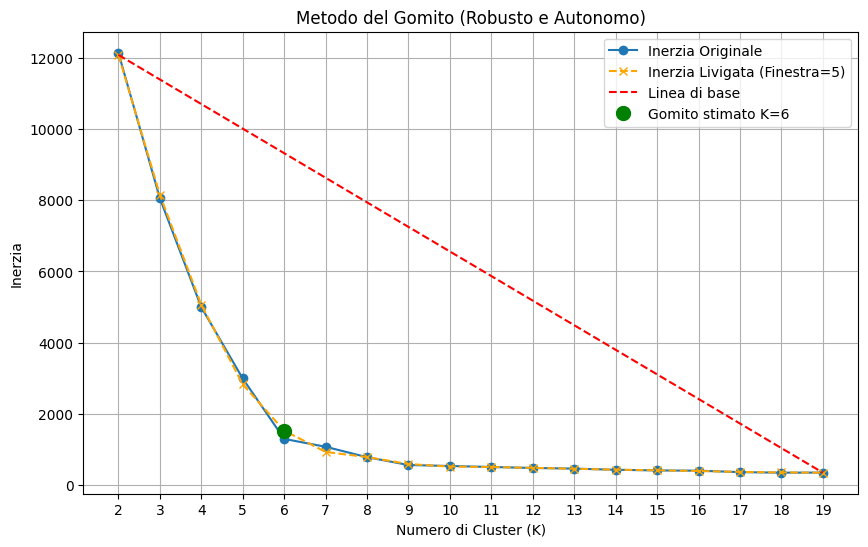

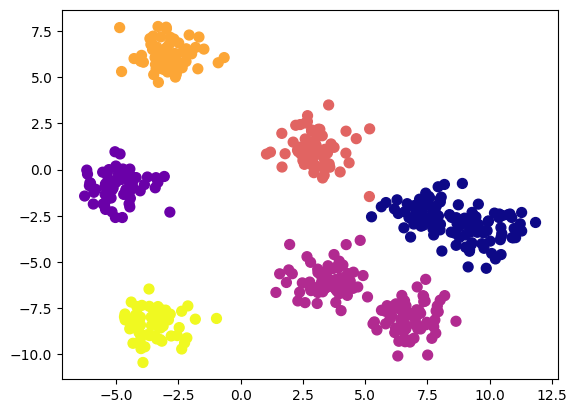

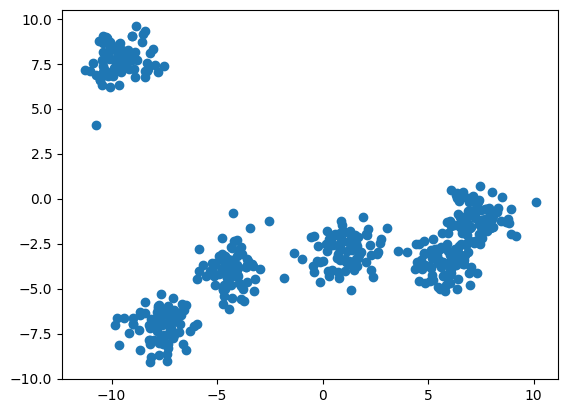

K ottimale stimato: 5 (Metodo distanza da linea, Smoothing: Adattiva (7))


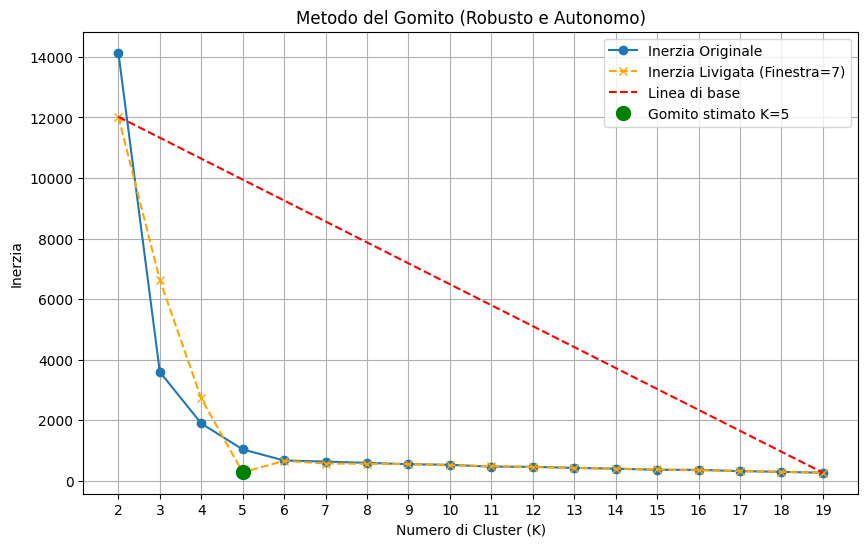

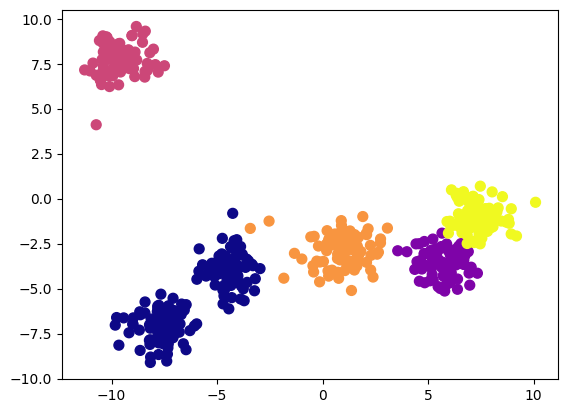

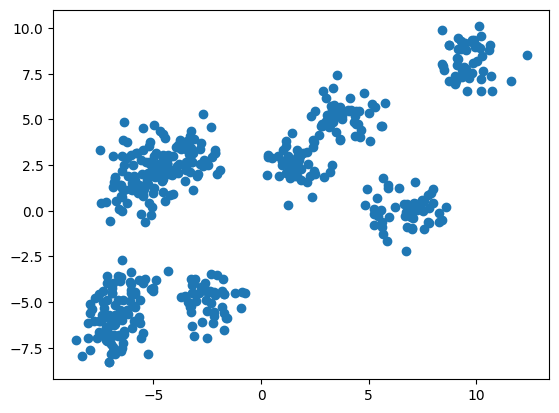

K ottimale stimato: 5 (Metodo distanza da linea, Smoothing: Adattiva (5))


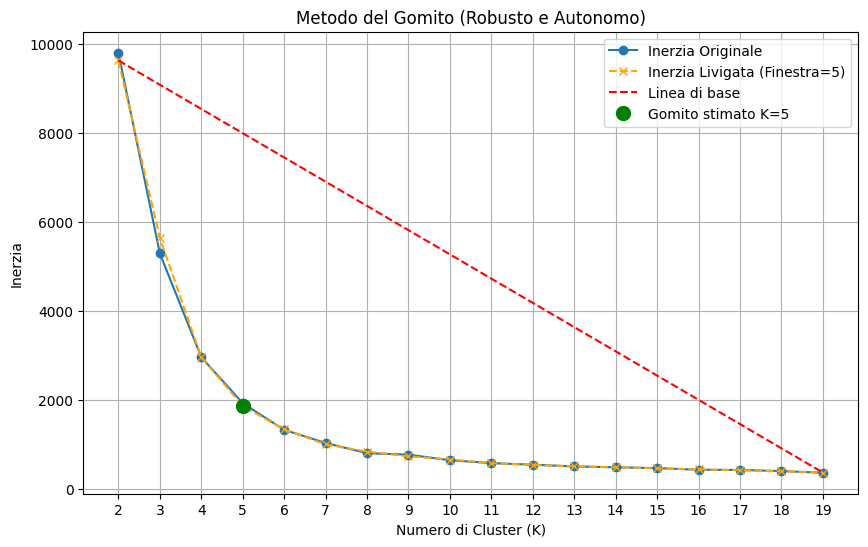

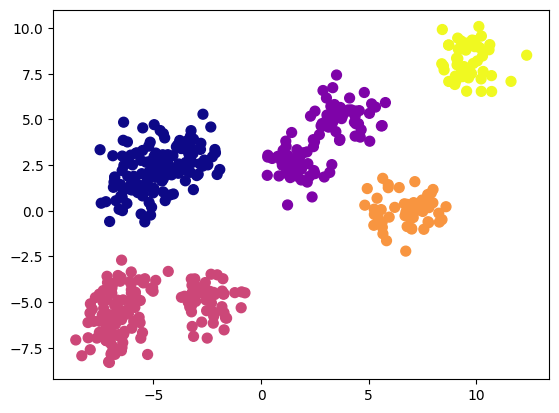

In [55]:
for i in range(1,10):
  X, val = getBlobs(i)
  plt.scatter(X[:,0],X[:,1])
  plt.show()
  
  cur_ssd = {}
  
  for k in range(2,20):
    kmeans = KMeans(init="k-means++", n_clusters=k)
    kmeans.fit(X)
    cur_ssd[k] = kmeans.inertia_
    
  cur_k = automatize_elbow_method(list(cur_ssd.keys()), list(cur_ssd.values()))
  
  kmeans_def = KMeans(init="k-means++", n_clusters=cur_k)
  kmeans_def.fit(X)
  cur_y_def = kmeans_def.predict(X)
  
  plt.scatter(X[:,0], X[:,1], c=cur_y_def, s=50, cmap="plasma")
  plt.show()
  # plt.scatter(centroids_def[:, 0], centroids_def[:, 1], c='green', s=200, alpha=0.8)
    

il tentativo di automatizzare l'elbow method non ha funzionato al 100% ma ha comunque restituito risultati interessanti